# Real and Fake Face Detection
Bu projede, gerçek veya sahte yüzü tahmin etmek için bir CNN kullanan küçük bir uygulama bulunmaktadır.

Veriler Kaggle'dan toplandı. Eğitim için yaklaşık 1450 görüntü ve doğrulama için ek olarak yaklaşık 300 görüntü kullanılmıştır.

In [21]:
# Keras'tan Sequential modelini içe aktarır. (Model oluşturmak için kullanılır)
from keras.models import Sequential

# Keras'tan Conv2D, Flatten, Dense ve MaxPool2D katmanlarını içe aktarır. (Sinir ağı katmanlarını oluşturmak için kullanılır)
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D

# NumPy'ı np olarak içe aktarır. (Nümerik hesaplamalar için kullanılır)
import numpy as np

# Keras'ın image modülünü içe aktarır ve ona image adını atar. (Görüntü işleme ile ilgili yardımcı işlevleri içerir)
import keras.utils as image

# Keras'tan EarlyStopping ve ModelCheckpoint geri aramalarını içe aktarır. (Eğitim sürecini kontrol etmek ve en iyi modeli kaydetmek için kullanılır)
from keras.callbacks import EarlyStopping, ModelCheckpoint

# TensorFlow'u tf olarak içe aktarır. (Derin öğrenme için popüler bir açık kaynak kütüphane)
import tensorflow as tf

# Keras'tan ImageDataGenerator sınıfını içe aktarır. (Veri artırma ve veri öncesi işleme işlemleri için kullanılır)
from keras.preprocessing.image import ImageDataGenerator

# Matplotlib'ı plt olarak içe aktarır. (Grafikleri çizmek ve görselleştirmek için kullanılır)
import matplotlib.pyplot as plt

# Jupyter Notebook veya Jupyter Lab ortamında matplotlib'in grafiklerini içeride görüntülemek için kullanılır.
%matplotlib inline

In [22]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation # geriye dönük uyumluluk uyarılarının yönetimini sağlayan modülü yüklüyoruz.
deprecation._PER_MODULE_WARNING_LIMIT = 0 #hataların görüntülenmesini engelliyor.

# 1- Veri Setinin Yüklenmesi

İlk olarak, programdan topladığımız verileri yükleyelim. Verileri hem dizinlerden etiketleyecek hem de hafifçe kaydırmalar, döndürmeler, yakınlaştırmalar ve yansıtmalarla veriyi hafifçe artıracak olan keras'ın ImageDataGenerator'ını kullanacağız. Yansıtma, verilerin belirli bir el tercihine yanlışlıkla yönlendirilmediğinden emin olmamıza yardımcı olacaktır.

In [23]:
nbatch = 128
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10.,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('dataset/training',
                                                 target_size=(128,128),
                                                 batch_size = nbatch,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('dataset/test',
                                            target_size=(128,128),
                                            batch_size = nbatch,
                                            class_mode = 'binary')

Found 2041 images belonging to 2 classes.
Found 604 images belonging to 2 classes.


***
# 2- CNN Modelinin Oluşturulması:
Aşağıdaki kodlar, eğitim ve test veri kümelerinin sınıf dağılımını histogram olarak görselleştirir.

Eğitim veri kümesi için mavi renkte,

test veri kümesi için kırmızı renkte sütunlar oluşturulur. Y ekseni 'Örnek Sayısı' olarak gösterilirken, X ekseni 'Sınıf' adıyla gösterilir.
***

Text(0.5, 0, 'Sınıf')

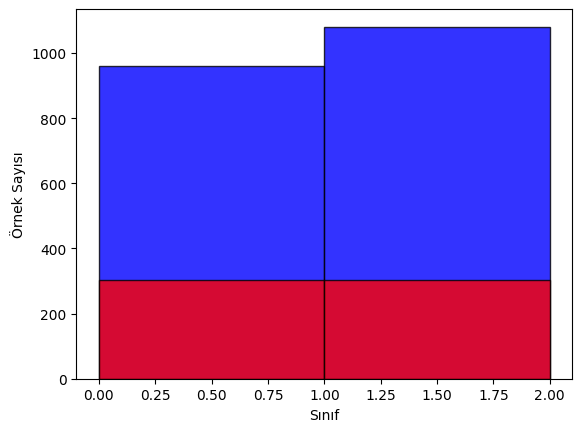

In [24]:
h1 = plt.hist(training_set.classes, bins=range(0, 3), alpha=0.8, color='blue', edgecolor='black') # training klasörü
h2 = plt.hist(test_set.classes, bins=range(0, 3), alpha=0.8, color='red', edgecolor='black') # test klasörü
plt.ylabel('Örnek Sayısı')
plt.xlabel('Sınıf')


***
Aşağıdaki kod parçası, eğitim veri setinden örnek bir toplu işlemini alır ve her bir görüntüyü ve başlığını ekrana ve grafiklere yansıtır.
***

(128, 128, 128, 3) (128,)


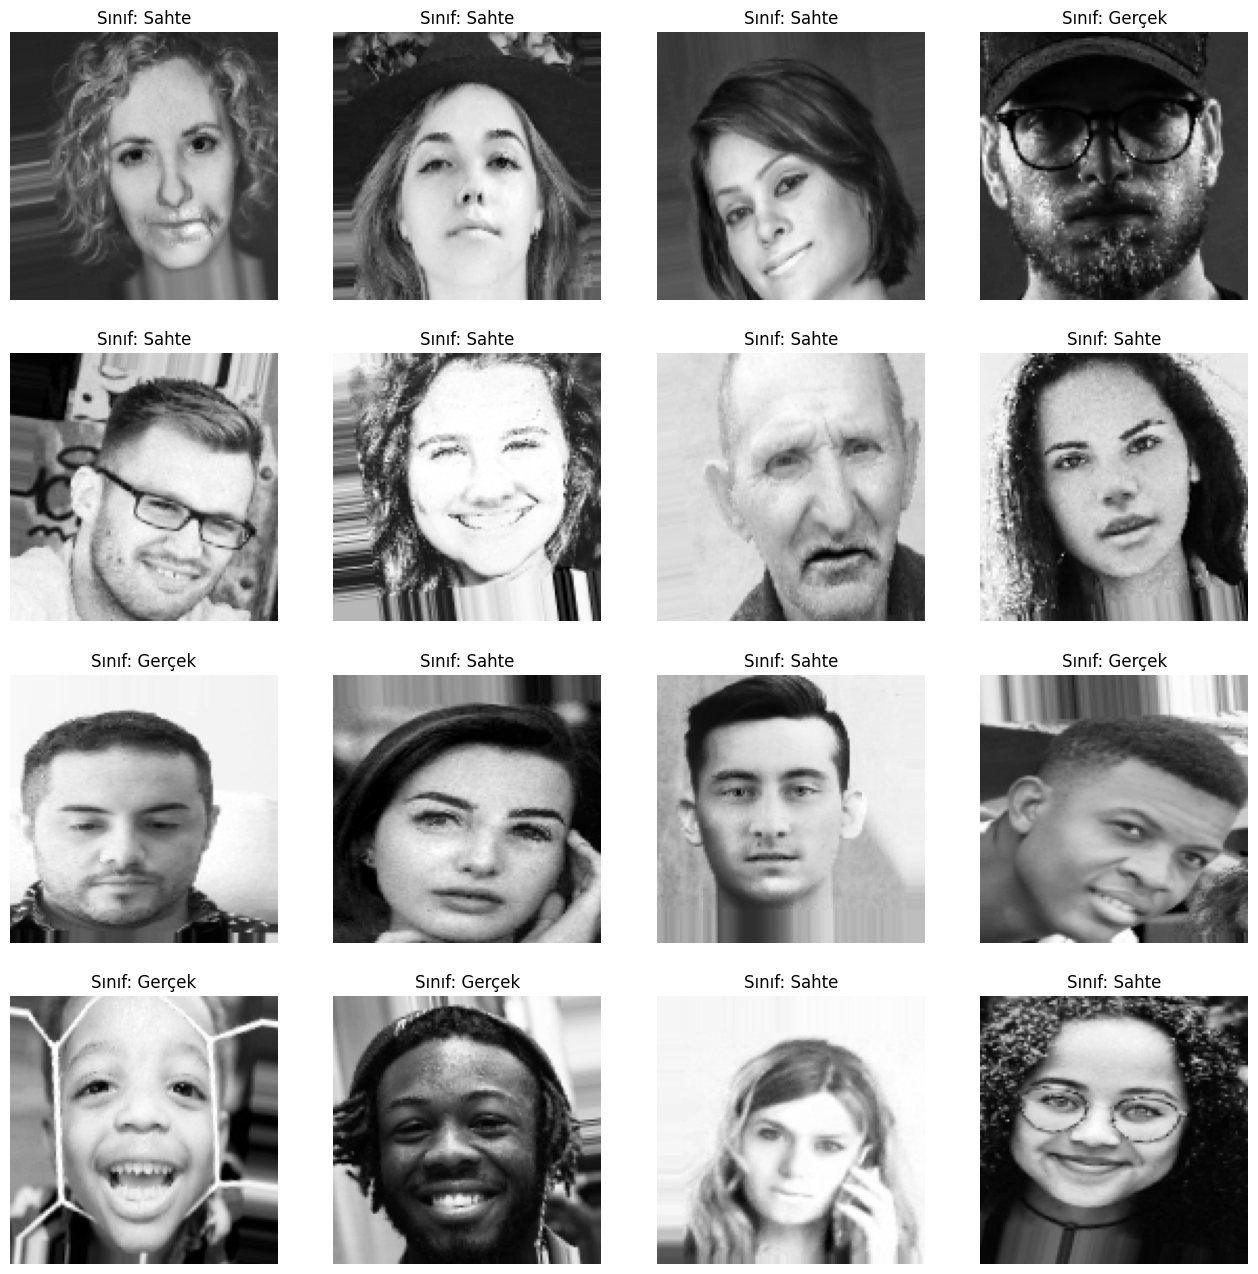

In [25]:
for X, y in training_set: # Eğitim veri kümesinden toplu işlem alınır ve döngü içinde işlenir.
    print(X.shape, y.shape) # Her bir toplu işlemin görüntü ve etiket dizilerinin boyutları ekrana yazdırılır.
    plt.figure(figsize=(16,16)) # 16x16 inç boyutunda bir çizim alanı (figür) oluşturulur.
    for i in range(16): # İlk 16 görüntü üzerinde işlem yapılır.
        plt.subplot(4,4,i+1) # 4x4 alt grafiklerden oluşan yerleşimi belirler.
        plt.axis('off') # Alt grafiklerin eksenlerini kapatır. 
        label = "Gerçek" if y[i] == 1 else "Sahte"  # Etikete göre Gerçek veya Sahte olarak etiketleri belirler.
        plt.title('Sınıf: ' + label)  # Alt grafiklerin başlık kısmına etiketi ekler.
        img = np.uint8(255*X[i,:,:,0]) # Görüntünün piksel değerleri 0-255 aralığına dönüştürülür.
        plt.imshow(img, cmap='gray') # Gri tonlamalı olarak görüntü görselleştirilir.
    break # Sadece ilk toplu işlemi işlendikten sonra döngüyü sonlandırır.

# 3- Evrişimli Sinir Ağı (CNN) Modelinin Tanımlanması

Veriler uygun görünüyor, bu yüzden şimdi uygulamamızda kullanmak üzere bir CNN (Evrişimli Sinir Ağı) modeli tanımlayacağız.

In [26]:
model = Sequential()  # Boş bir sıralı derin öğrenme modeli oluşturuluyor.

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
# 32 adet 3x3 boyutunda filtre kullanarak bir evrişim katmanı ekleniyor.
# ReLU aktivasyon fonksiyonu, negatif değerleri sıfıra düşürerek pozitif değerleri korur.

model.add(MaxPool2D(pool_size=(2, 2)))
# 2x2 boyutunda bir max pooling katmanı ekleniyor.
# Giriş alanını küçültür ve önemli özellikleri vurgular.

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# 64 adet 3x3 boyutunda filtre kullanarak bir evrişim katmanı ekleniyor.
# ReLU aktivasyon fonksiyonu, negatif değerleri sıfıra düşürerek pozitif değerleri korur.

model.add(MaxPool2D(pool_size=(2, 2)))
# 2x2 boyutunda bir max pooling katmanı ekleniyor.
# Giriş alanını küçültür ve önemli özellikleri vurgular.

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# 128 adet 3x3 boyutunda filtre kullanarak bir evrişim katmanı ekleniyor.
# ReLU aktivasyon fonksiyonu, negatif değerleri sıfıra düşürerek pozitif değerleri korur.

model.add(MaxPool2D(pool_size=(2, 2)))
# 2x2 boyutunda bir max pooling katmanı ekleniyor.
# Giriş alanını küçültür ve önemli özellikleri vurgular.

model.add(Flatten())
# Verileri düzleştirerek vektör haline getirir.
# Tam bağlantılı (fully connected) katmanlara giriş yapabilmek için gerekli bir adımdır.

model.add(Dense(activation="relu", units=256))
# ReLU aktivasyon fonksiyonu ve 256 nöron içeren bir tam bağlantılı katman ekleniyor.
# Doğrusal olmayan ilişkileri modellemek için kullanılır.

model.add(Dense(activation="sigmoid", units=1))
# Sigmoid aktivasyon fonksiyonu ve 1 nöron içeren bir çıkış katmanı ekleniyor.
# İkili sınıflandırma problemlerinde kullanılır ve sonuçları 0 ile 1 arasında olasılık değerleri olarak yorumlar.

model.summary()
# Modelin özetini gösterir.
# Modelin katmanlarını, parametre sayılarını ve her katmandan geçen veri boyutlarını görüntüler.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 128)     

# 4- CNN Modelinin Tablo Özeti
Yukarıdaki bölüm, modelin yapısını ve parametre sayılarını özetleyen bir model özetidir.

Model adı: "sequential"

Katmanlar: İlgili katmanların sıralı bir listesi olarak görüntülenir.

Çıktı şekilleri: Her katmanın çıktı şekli bu bölümde listelenir.

Parametre sayısı: Her katmandaki toplam parametre sayısı bu bölümde gösterilir.

Trainable params: Eğitilebilir parametrelerin toplam sayısıdır. Bu parametreler, modelin eğitimi sırasında güncellenir.

Non-trainable params: Eğitilemez parametrelerin toplam sayısıdır. Bunlar, genellikle önceden eğitilmiş ağırlıklar veya sabit değerlerdir.

Bu özet, modelin yapısını ve toplam parametre sayısını göstererek modelin genel bir görünümünü sağlar.

# 5- Modeli Derleme İşlemi
Bu kod, modelin eğitim öncesi hazırlıklarının yapıldığı aşamadır. Derlenmiş model, eğitime başlamaya ve sonuçları değerlendirmeye hazır hale gelir.

Adam (Adaptive Moment Estimation), gradient tabanlı bir optimize edici algoritmadır. Adam, adaptif bir öğrenme hızı yöntemi olan RMSProp ve momentum yöntemini birleştirerek çalışır.

Adam algoritması, her parametrenin öğrenme hızını ayrı ayrı ayarlar. Bunun için iki önemli terim kullanır: momentum ve RMSProp (Root Mean Square Propagation).

Momentum: Parametre güncellemelerini hızlandırmak ve daha hızlı konverjans sağlamak için kullanılır. Önceki güncellemelerin bir kombinasyonunu hesaplar ve buna göre yeni bir güncelleme yapar.

RMSProp: Gradientlerin ölçeğini düzenlemek için kullanılır. Gradientlerin karelerinin hareketli ortalamasını hesaplar ve böylece daha büyük gradientlere sahip parametrelerin öğrenme hızını azaltırken, daha küçük gradientlere sahip parametrelerin öğrenme hızını artırır.

Adam, momentum ve RMSProp yöntemlerini birleştirerek her parametrenin öğrenme hızını adaptif bir şekilde ayarlar. Bu şekilde, optimize edici algoritma, hızlı konverjans sağlayabilir ve farklı parametrelerin farklı ölçeklere sahip olması durumunda daha iyi performans elde edebilir.

Kısacası, Adam algoritması, momentum ve RMSProp yöntemlerini birleştirerek gradient tabanlı parametre güncellemelerini yönetir. Bu şekilde, daha hızlı ve adaptif bir öğrenme hızı sağlar ve modelin daha iyi sonuçlar elde etmesine yardımcı olur.

In [27]:
model.compile(optimizer='adam',  # Modelin optimize edici olarak Adam algoritmasını kullanmasını sağlar.
              loss='binary_crossentropy',  # Hedef fonksiyonunun kaybını binary cross-entropy ile hesaplar. 
              metrics=['accuracy'])  # Eğitim ve doğrulama sırasında izlenecek metrik olarak doğruluğu kullanır.

# 6- Eğitim
Son olarak, modelimizi keras yardımcı fonksiyonlarını kullanarak eğiteceğiz. Herhangi bir hiper-parametre optimizasyonu yapmadığımız için ayrı bir test ve doğrulama seti tanımlamayacağız. Bununla birlikte, modelimizi uygulama içinde gerçek zamanlı olarak daha fazla değerlendirebiliriz.

In [28]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=10),  # Eğitimi erken durdurma işlemi.
    ModelCheckpoint(filepath='model_checkpoint.hdf5', monitor='val_loss', save_best_only=True, mode='max'),  # En iyi modeli kaydetme işlemi.
]

# 6.1- CNN Modelinin Eğitimi ve Doğrulama

Bu kod parçası, bir Evrişimli Sinir Ağı (CNN) modelini eğitmek ve doğrulamak için kullanılmaktadır. 

In [29]:
history = model.fit_generator(
    training_set,  # Eğitim veri kümesi
    steps_per_epoch=80,  # Her bir epoch'ta kullanılacak adım sayısı
    epochs=20,  # Toplam epoch sayısı
    validation_data=test_set,  # Doğrulama veri kümesi
    validation_steps=28,  # Her bir doğrulama adımı için kullanılacak adım sayısı
    callbacks=callbacks_list  # Geri çağrı işlevleri listesi
)

C:\Users\BAYDEMIR\AppData\Local\Temp\ipykernel_18480\1722804215.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
80/80 [==============================] - 61s 703ms/step - loss: 0.7433 - accuracy: 0.5218 - val_loss: 0.6934 - val_accuracy: 0.5000


training_set.class_indices kodu, eğitim veri kümesindeki sınıfların indekslerini ve bunlara karşılık gelen etiketleri içeren bir sözlük olarak döndürür. Bu sözlük, veri kümesindeki sınıfların isimleri ve bunlara atanan sayısal indeksleri eşleştirir.

Örneğin, eğer eğitim veri kümesinde "köpek" sınıfı için indeks 0, "kedi" sınıfı için indeks 1 olarak atandıysa, training_set.class_indices sözlüğü şu şekilde olabilir:

{'köpek': 0, 'kedi': 1}

Bu bilgi, modelin tahmin sonuçlarını sayısal indekslerden sınıf isimlerine dönüştürmek veya veri kümesindeki sınıflara ilişkin işlemler yapmak için kullanılabilir.

In [30]:
training_set.class_indices

{'fake': 0, 'real': 1}

# 7- Kayıp ve Doğruluk
Aşağıdaki kod, eğitim sırasında kaydedilen loss (kayıp) ve accuracy (doğruluk) metriklerinin eğitim ve test veri kümesi üzerindeki değişimini görselleştirmek için kullanılır.

İlk olarak, plt.figure(figsize=(16,6)) ile bir figür oluşturulur ve boyutu belirlenir.

Ardından, plt.subplot(1,2,1) ile figür içindeki ilk grafik paneli belirlenir.

range(nepochs) ve history.history['loss'] kullanılarak eğitim kaybı verisi çizdirilir.

Aynı şekilde, range(nepochs) ve history.history['val_loss'] kullanılarak test kaybı verisi çizdirilir.

plt.ylabel('loss') ve plt.xlabel('# of epochs') ile y ekseni ve x ekseni etiketlenir.

İkinci grafik paneli için aynı adımlar tekrarlanır, ancak bu sefer accuracy (doğruluk) verileri çizdirilir.

Text(0.5, 0, '# islenen veri')

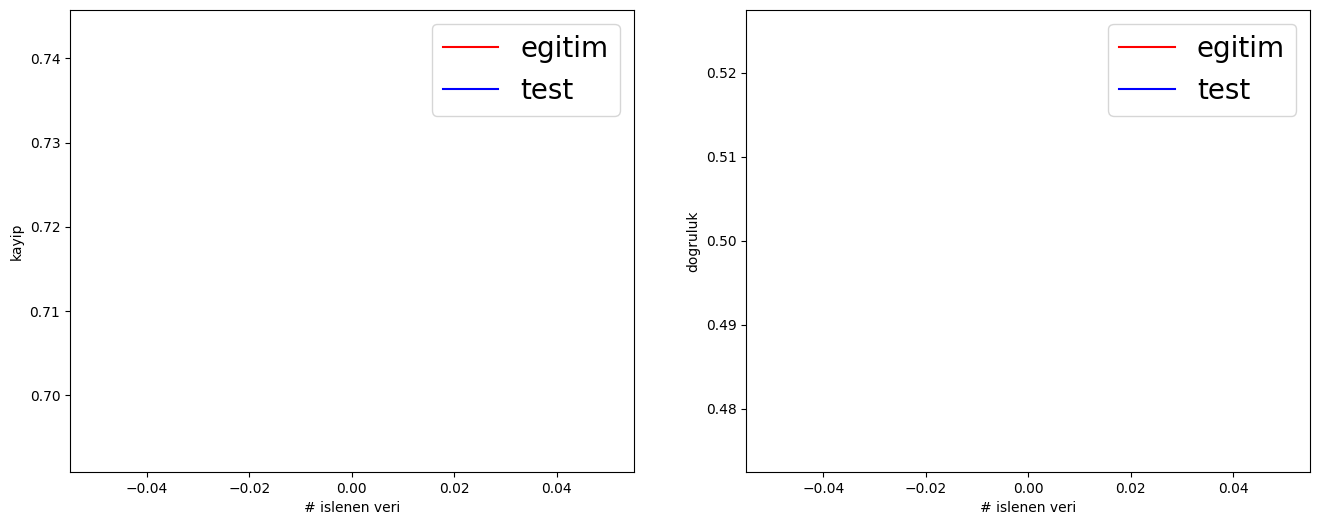

In [31]:
plt.figure(figsize=(16,6)) # figür oluşturuldu ve boyutu belirlendi.
plt.subplot(1,2,1) #Figür grafik paneli belirlendi.
nepochs=len(history.history['loss'])
plt.plot(range(nepochs), history.history['loss'],     'r-', label='egitim')
plt.plot(range(nepochs), history.history['val_loss'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('kayip')
plt.xlabel('# islenen veri')
plt.subplot(1,2,2)
plt.plot(range(nepochs), history.history['val_accuracy'],     'r-', label='egitim')
plt.plot(range(nepochs), history.history['val_accuracy'], 'b-', label='test')
plt.legend(prop={'size': 20})
plt.ylabel('dogruluk')
plt.xlabel('# islenen veri') # epoch: Bir makine öğrenimi modelinin eğitimi sırasında tüm verilerin bir kez model tarafından işlendiği ve güncellendiği dönemdir.

# 8- Tahmin
Artık model eğitildiği için bazı gerçek görüntüleri kullanarak ve bu görüntüleri düzenleyerek modelin doğru çalışıp çalışmadığını değerlendireceğiz.

***
Aşağıdaki kod, verilen bir görüntüyü kullanarak modelimizin tahmin yapmasını sağlar.

İlk olarak, belirtilen konumdaki görüntü yüklenir ve boyutu (128, 128) olarak hedeflenir.

Görüntü matplotlib kütüphanesi kullanılarak görselleştirilir.

Görüntü numpy dizisine dönüştürülür ve boyutu genişletilir.

Model, test görüntüsü üzerinde tahmin yapar.

Elde edilen tahmin sonucuna göre, görüntünün "Real" (gerçek) veya "Fake" (sahte) olduğu belirlenir.

Son tahmin ekrana yazdırılır.

Bu kod, modelin gerçek veya sahte bir görüntüyü doğru bir şekilde tahmin edebilmesini sağlar.

In [32]:
def ImagePrediction(loc):
    test_image = image.load_img(loc, target_size = (128,128))
    plt.axis('off')
    plt.imshow(test_image)
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis =0)
    result = model.predict(test_image)
    if result[0][0] == 1:
        predictions = 'Real'
    else:
        predictions = 'Fake'
    print('Prediction: ',predictions)

In [33]:
img = input("Enter Location of Image to predict: ")
test_image_1 = ImagePrediction(img)

1/1 [==============================] - 0s 53ms/step
Prediction:  Fake


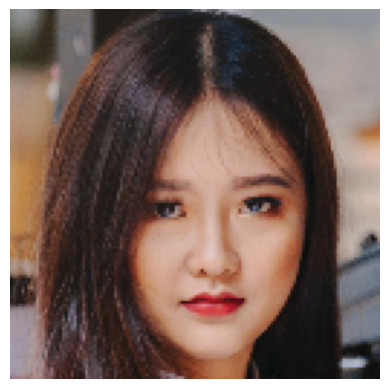

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_2 = ImagePrediction(img)

1/1 [==============================] - 0s 40ms/step
Prediction:  Fake


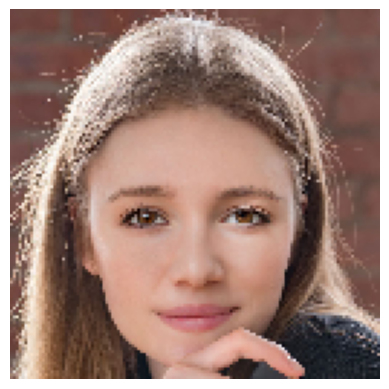

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

1/1 [==============================] - 0s 40ms/step
Prediction:  Fake


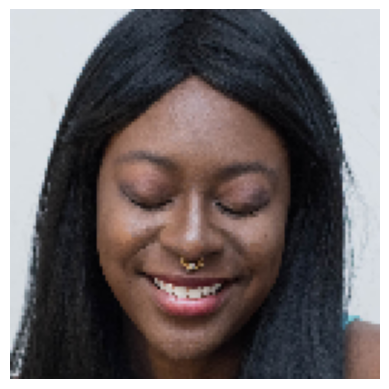

In [ ]:
img = input("Enter Location of Image to predict: ")
test_image_3 = ImagePrediction(img)

# Sonuç
4 resmin ..'ü doğru bir şekilde tahmin edildi, ancak model iyi bir şekilde eğitilmemiş olmasına rağmen epok sayısını yaklaşık 40'a çıkarmak bu modelin tamamen eğitilmesini sağlayabilir, ancak bu eğitim için 5-6 saat gerekecektir.